In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
import warnings
warnings.filterwarnings("ignore")
import sys
sys.path.append('../..')

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
from collections import defaultdict
from sklearn.metrics import adjusted_rand_score
from scipy.stats import rankdata
import itertools

In [3]:
from pygraphs.cluster import KernelKMeans, Ward, KernelKMeansSklearn, KernelWardSklearn
from pygraphs.graphs.generator import StochasticBlockModel, RubanovModel
from pygraphs.measure import *
from pygraphs.measure import distances, scaler
from pygraphs.scenario import plot_results, d3_right_order, measures_right_order

In [4]:
best_params_100_2_01 = {
    'pWalk': 0.77,
    'FE': 0.93,
    'Comm': 0.33,
    'logFor': 0.47,
    'logComm': 0.57,
    'Walk': 0.7,
    'For': 0.97,
    'SCT': 0.43,
    'Heat': 0.87,
    'logHeat': 0.47,
    'SCCT': 0.99,
    'SP-CT': 0.03,
    'RSP': 0.97,
    'SP': 0,
    'CT': 0
}

# Берем функцию распределения (кумулятивную, S-образная кривая) ненулевых внутриклассовых расстояний и вычитаем из нее функцию распределения межклассовых расстояний. Должна получиться n-образная кривая. Преимущество ее, например, в том, что она показывает интервал, на котором распределено расстояние.

Для эффектности ее можно продифференцировать - тогда экстремумы покажут точки сосредоточения тех и других расстояний. Аналогично можно делать для kernels - будет видно, на distances основной эффект оказывают диагональные или недиагональные эл-ты kernels. (Кстати, недостаток commute time, возможно, - в доминировании эффекта диагонали kernel. И для Forest, возможно, дело в том же.)

Это хорошо бы сделать для heat, кот. вел себя странно.


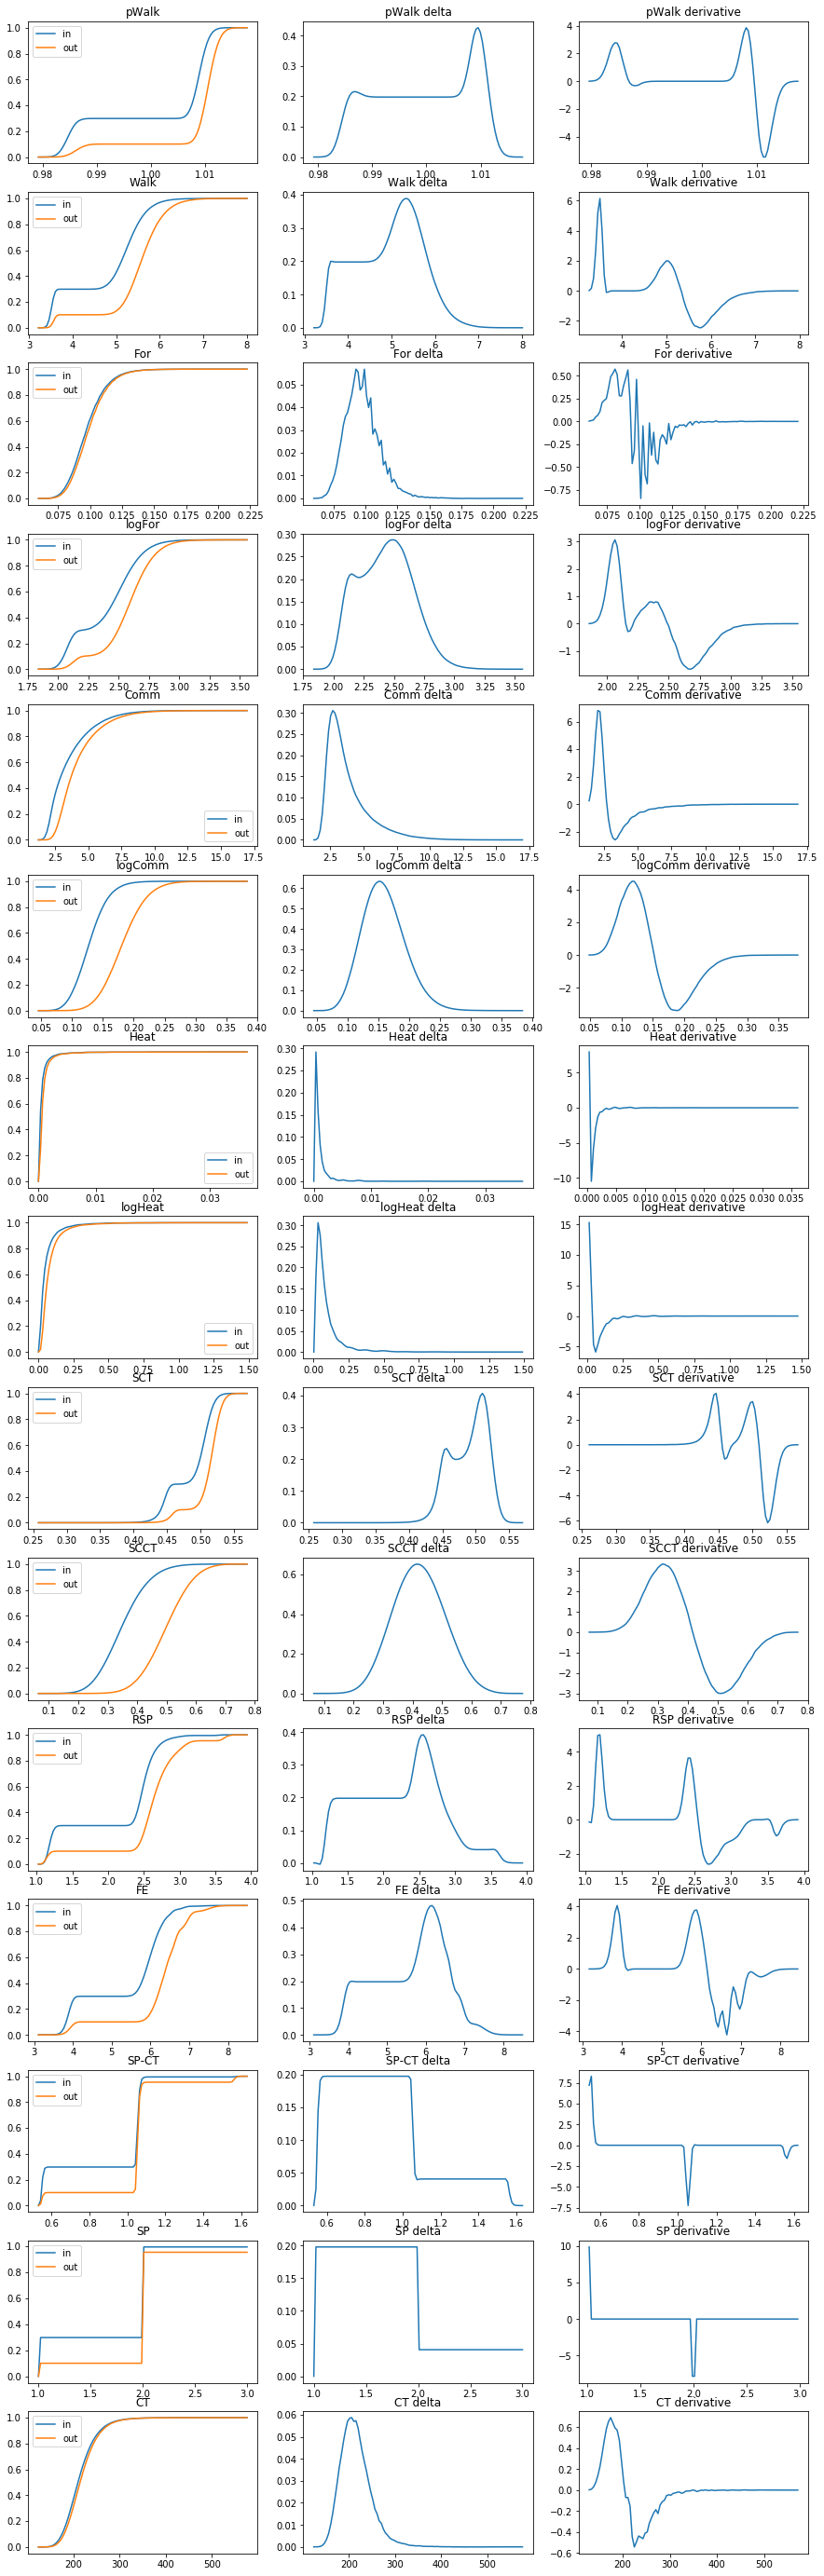

In [5]:
graphs, info = StochasticBlockModel(100, 2, p_in=0.3, p_out=0.1).generate_graphs(100)
clf = KernelWardSklearn(2)
results = defaultdict(list)
fig, ax = plt.subplots(15, 3, figsize=(15, 50))
for distance_idx, distance_class in enumerate(tqdm(distances)):
#     if distance_idx == 14:
#         continue
        
    in_distances, out_distances = [], []
    for edges, nodes in graphs:
        distance = distance_class(edges)
        param_flat = best_params_100_2_01[distance.name]
        param = distance.scaler.scale(0.5)
        D = distance.get_D(param)
        
        for i in range(D.shape[0]):
            for j in range(i + 1, D.shape[1]):
                same_class = nodes[i] == nodes[j]
                if same_class:
                    in_distances.append(D[i, j])
                else:
                    out_distances.append(D[i, j])
                    
    min_dist = np.min([np.min(in_distances), np.min(out_distances)])
    max_dist = np.max([np.max(in_distances), np.max(out_distances)])
    
    x = np.linspace(min_dist, max_dist, 100)
    
    in_cumsum = []
    for i in x:
        in_cumsum.append(np.sum(in_distances < i))
    in_cumsum = np.array(in_cumsum) / len(in_distances)

    out_cumsum = []
    for i in x:
        out_cumsum.append(np.sum(out_distances < i))
    out_cumsum = np.array(out_cumsum) / len(out_distances)
        
    ax[distance_idx][0].plot(x, in_cumsum, label='in')
    ax[distance_idx][0].plot(x, out_cumsum, label='out')
    ax[distance_idx][0].legend()
    ax[distance_idx][0].set_title(distance.name)
    
    delta = in_cumsum - out_cumsum
    ax[distance_idx][1].plot(x, delta)
    ax[distance_idx][1].set_title('{} delta'.format(distance.name))
    
    deriv = (delta[2:] - delta[:-2]) / (2 * 0.01)
    ax[distance_idx][2].plot(x[1:-1], deriv)
    ax[distance_idx][2].set_title('{} derivative'.format(distance.name))
    
plt.show()